In [1]:
import os
import logging
from typing import List, Optional
import wandb

import pandas as pd

import torch

import nll_to_po.models.dn_policy as Policy
from nll_to_po.training.utils import train_single_policy, setup_logger
import nll_to_po.training.loss as L
import nll_to_po.training.reward as R

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_palette("colorblind")
sns.despine()

logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)
os.environ["WANDB_SILENT"] = "true"  # Suppress WandB output

<Figure size 640x480 with 0 Axes>

### config

In [20]:
df_list: list[pd.DataFrame] = []

In [21]:
# Experiment parameters
n_experiments: int = 10
n_updates: int = 100
learning_rate: float = 0.01
use_wandb: bool = False
wandb_project: str = "tractable"

# Policy architecture
input_dim: int = 2
output_dim: int = 2
hidden_sizes: list[int] = [64, 64]
fixed_logstd: bool = True

# Data generating dist q
A = torch.randn((output_dim, input_dim))
init_dist_loc: float = 0.0
init_dist_scale: float = 0.75
init_dist_n_samples: int = 10
train_size: int = 100
val_size: int = 100

### Policy model

In [22]:
# policy = Policy.LinearGaussian(input_dim, output_dim, fixed_logstd)
policy = Policy.MLPPolicy(input_dim, output_dim, hidden_sizes, fixed_logstd)

### Generate data

In [23]:
def generate_data_linear():
    assert input_dim == output_dim, "we need square matrices for this application"
    X = torch.randn((train_size + val_size, input_dim))
    mean_y = X @ A.T + init_dist_loc
    y = mean_y + torch.randn(train_size + val_size, output_dim) * init_dist_scale
    # X = X.repeat(init_dist_n_samples, 1)  # Repeat X for each sample

    X_train, X_val = X[:train_size], X[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]

    # Create a DataLoader
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=X_train.shape[0], shuffle=True
    )
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset, batch_size=X_val.shape[0], shuffle=False
    )

    return train_dataloader, val_dataloader


def generate_data():
    # Generate new random data for each experiment
    X = torch.randn(1, input_dim)
    mean_y = torch.ones((1, output_dim)) * init_dist_loc
    y = mean_y + torch.randn(init_dist_n_samples, output_dim) * init_dist_scale
    X = X.repeat(init_dist_n_samples, 1)  # Repeat X for each sample
    batch_size = X.shape[0]

    # Create a DataLoader
    train_dataset = torch.utils.data.TensorDataset(X, y)
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )

    return train_dataloader, None

### Exp function

In [24]:
def run_exp(loss_function: L.LossFunction, config: Optional[dict] = None):
    for exp_idx in range(n_experiments):
        train_dataloader, val_dataloader = generate_data_linear()

        config["train_size"] = len(train_dataloader)
        if val_dataloader is not None:
            config["val_size"] = len(val_dataloader)
        config["loss_type"] = loss_function.name

        if use_wandb:
            wandb_run = wandb.init(
                project=wandb_project,
                config=config,
            )
        else:
            wandb_run = None
        logger, _, ts_writer = setup_logger(
            logger_name="nll_to_po",
            log_dir="../logs",
            env_id="test_theory",
            exp_name=f"{loss_function.name}_{exp_idx}",
        )
        # Log the configuration
        logger.info(f"%%%%%%%%%%%%%%%%%%%\nconfig:\n{config}\n%%%%%%%%%%%%%%%%%%%%")

        # Run comparison
        _, mse_train_metrics, mse_val_metrics = train_single_policy(
            policy=policy,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            loss_function=loss_function,
            n_updates=n_updates,
            learning_rate=learning_rate,
            wandb_run=wandb_run,
            tensorboard_writer=ts_writer,
            logger=logger,
            early_stopping_patience=100,
        )

        if use_wandb:
            wandb_run.finish()

        # Save to dataframe
        # train
        df = pd.DataFrame(mse_train_metrics).reset_index()
        df = df.rename(columns={"index": "epoch"})
        for k, v in config.items():
            df[k] = v
        df["experiment"] = exp_idx
        df["train_val"] = "train"
        df_list.append(df)
        # val
        df = pd.DataFrame(mse_val_metrics).reset_index()
        df = df.rename(columns={"index": "epoch"})
        for k, v in config.items():
            df[k] = v
        df["experiment"] = exp_idx
        df["train_val"] = "val"
        df_list.append(df)

### Baselines: MSE & NLL

In [25]:
config = {
    "fixed_logstd": fixed_logstd,
    "init_dist_loc": init_dist_loc,
    "init_dist_scale": init_dist_scale,
    "learning_rate": learning_rate,
}
for loss_function in [L.MSE(), L.NLL()]:
    run_exp(loss_function=loss_function, config=config)

2025-08-15 22:35:57 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'fixed_logstd': True, 'init_dist_loc': 0.0, 'init_dist_scale': 0.75, 'learning_rate': 0.01, 'train_size': 1, 'val_size': 1, 'loss_type': 'MSE'}
%%%%%%%%%%%%%%%%%%%%
2025-08-15 22:35:57 - nll_to_po - INFO - Starting training for 100 epochs
Training epochs: 100%|██████████| 100/100 [00:00<00:00, 237.18it/s]
2025-08-15 22:35:58 - nll_to_po - INFO - Training completed after 100 epochs
2025-08-15 22:35:58 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'fixed_logstd': True, 'init_dist_loc': 0.0, 'init_dist_scale': 0.75, 'learning_rate': 0.01, 'train_size': 1, 'val_size': 1, 'loss_type': 'MSE'}
%%%%%%%%%%%%%%%%%%%%
2025-08-15 22:35:58 - nll_to_po - INFO - Starting training for 100 epochs
Training epochs: 100%|██████████| 100/100 [00:00<00:00, 267.50it/s]
2025-08-15 22:35:58 - nll_to_po - INFO - Training completed after 100 epochs
2025-08-15 22:35:58 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'fixed_logstd': True, 

### PG Entropy Reg

In [30]:
n_generations: int = 5
use_rsample: bool = False
reward_transform: str = "normalize"

for entropy_weight in [0.1, 1.0, 10.0]:
    # Define reward function
    reward_constant_diagonal: float = entropy_weight / (init_dist_scale**2)
    reward_fn = R.Mahalanobis(matrix=reward_constant_diagonal * torch.eye(output_dim))

    config = {
        "fixed_logstd": fixed_logstd,
        "init_dist_loc": init_dist_loc,
        "init_dist_scale": init_dist_scale,
        "learning_rate": learning_rate,
        "n_generations": n_generations,
        "use_rsample": use_rsample,
        "reward_transform": reward_transform,
        "entropy_weight": entropy_weight,
        "reward_fn": reward_fn.name,
        "U": r"$I$"
        if reward_constant_diagonal == 1.0
        else r"$\frac{\lambda}{\beta^2}$",
    }

    # Define the loss function
    loss_function = L.PG(
        reward_fn=reward_fn,
        n_generations=n_generations,
        use_rsample=use_rsample,
        reward_transform=reward_transform,
        entropy_weight=entropy_weight,
    )
    run_exp(loss_function=loss_function, config=config)

2025-08-15 22:37:40 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'fixed_logstd': True, 'init_dist_loc': 0.0, 'init_dist_scale': 0.75, 'learning_rate': 0.01, 'n_generations': 5, 'use_rsample': False, 'reward_transform': 'normalize', 'entropy_weight': 0.1, 'reward_fn': 'Mahalanobis(0.18)', 'U': '$\\frac{\\lambda}{\\beta^2}$', 'train_size': 1, 'val_size': 1, 'loss_type': 'PG(lam=0.1)_Mahalanobis(0.18)'}
%%%%%%%%%%%%%%%%%%%%
2025-08-15 22:37:40 - nll_to_po - INFO - Starting training for 100 epochs
Training epochs: 100%|██████████| 100/100 [00:00<00:00, 176.08it/s]
2025-08-15 22:37:41 - nll_to_po - INFO - Training completed after 100 epochs
2025-08-15 22:37:41 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'fixed_logstd': True, 'init_dist_loc': 0.0, 'init_dist_scale': 0.75, 'learning_rate': 0.01, 'n_generations': 5, 'use_rsample': False, 'reward_transform': 'normalize', 'entropy_weight': 0.1, 'reward_fn': 'Mahalanobis(0.18)', 'U': '$\\frac{\\lambda}{\\beta^2}$', 'train_size': 1, 'va

### plot

In [31]:
df_all = pd.concat(df_list, ignore_index=True)
df_all.head(3)

,epoch,mean_error,loss,grad_norm,fixed_logstd,init_dist_loc,init_dist_scale,learning_rate,train_size,val_size,...,NLL,std_0,std_1,entropy,n_generations,use_rsample,reward_transform,entropy_weight,reward_fn,U
0,0,4.912050,4.912050,3.009969,True,0.0,0.75,0.01,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,3.980309,3.980309,2.946852,True,0.0,0.75,0.01,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,3.171504,3.171504,3.257739,True,0.0,0.75,0.01,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


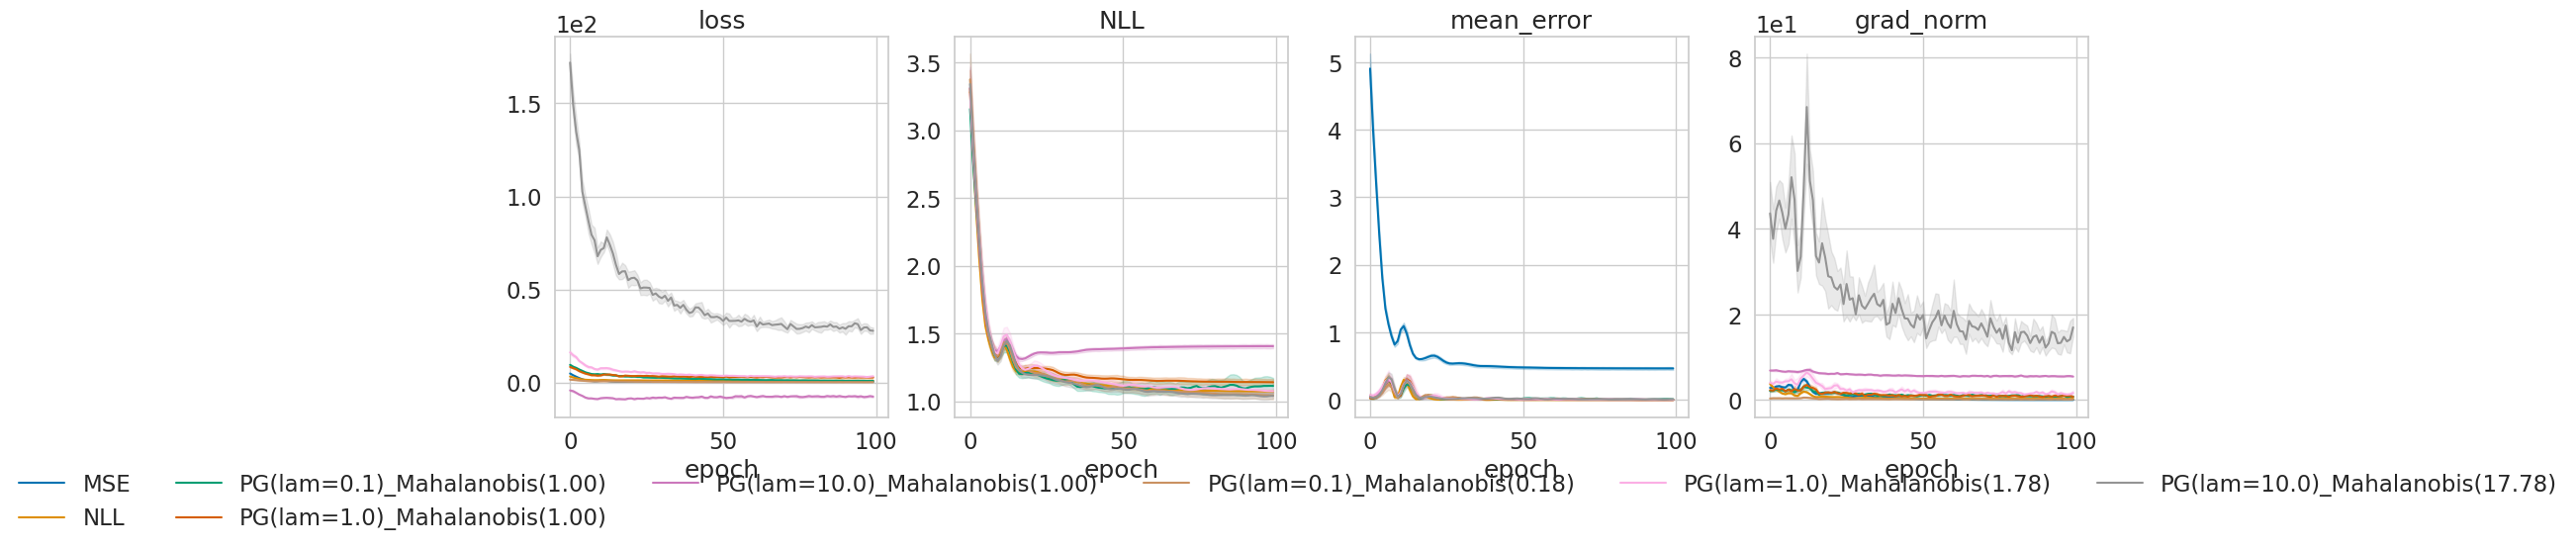

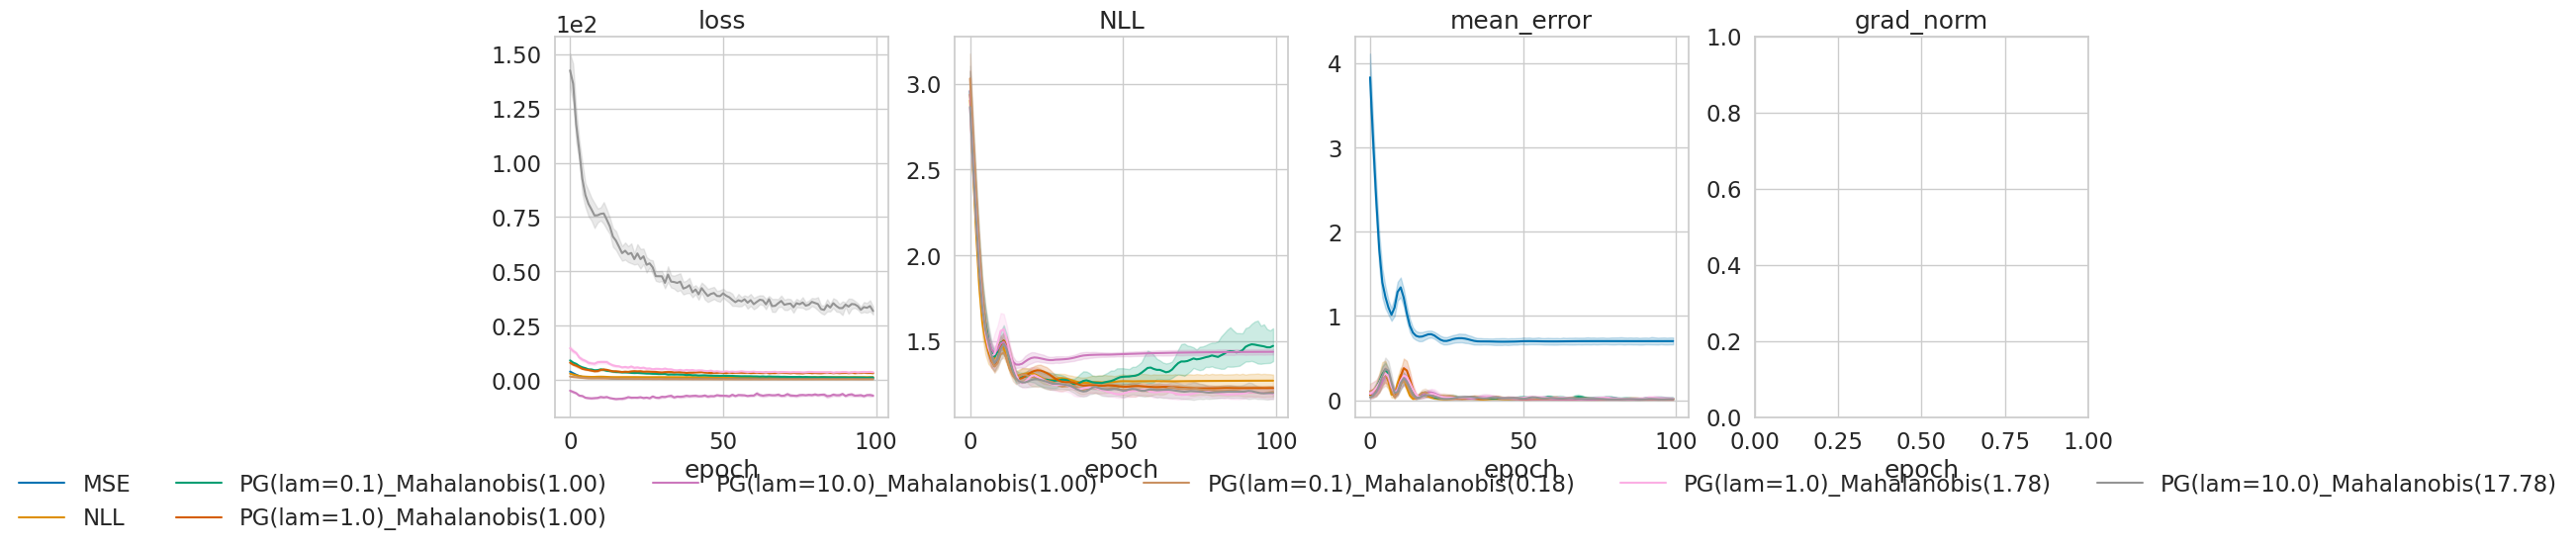

In [32]:
# train
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, metric in enumerate(["loss", "NLL", "mean_error", "grad_norm"]):
    sns.lineplot(
        data=df_all[df_all["train_val"] == "train"],
        x="epoch",
        y=metric,
        hue="loss_type",
        ax=ax[i],
        legend=False if i > 0 else True,
    )
    ax[i].set_ylabel(None)
    ax[i].set_title(metric)
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
ax[0].legend(bbox_to_anchor=(2.2, -0.35), loc="lower center", ncol=6, frameon=False)

# validation
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, metric in enumerate(["loss", "NLL", "mean_error", "grad_norm"]):
    sns.lineplot(
        data=df_all[df_all["train_val"] == "val"],
        x="epoch",
        y=metric,
        hue="loss_type",
        ax=ax[i],
        legend=False if i > 0 else True,
    )
    ax[i].set_ylabel(None)
    ax[i].set_title(metric)
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
ax[0].legend(bbox_to_anchor=(2.2, -0.35), loc="lower center", ncol=6, frameon=False)
plt.show()

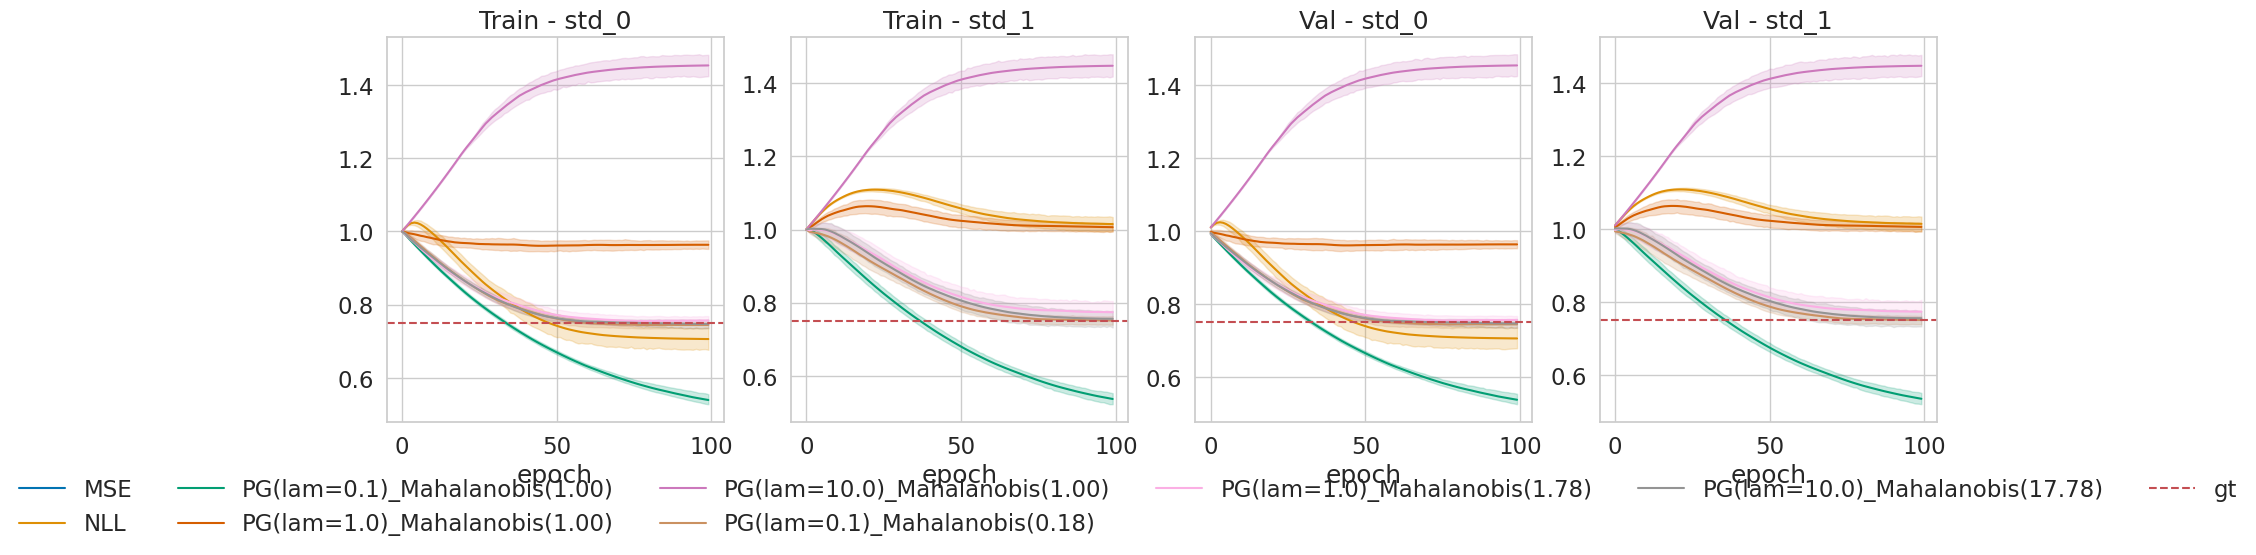

In [33]:
# train
fig, ax = plt.subplots(1, output_dim * 2, figsize=(20, 5))
for i in range(output_dim):
    sns.lineplot(
        data=df_all[df_all["train_val"] == "train"],
        x="epoch",
        y=f"std_{i}",
        hue="loss_type",
        ax=ax[i],
        legend=False if i > 0 else True,
    )
    ax[i].set_ylabel(None)
    ax[i].set_title(f"Train - std_{i}")
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
    ax[i].axhline(y=init_dist_scale, color="r", linestyle="--", label="gt")
for i in range(output_dim):
    sns.lineplot(
        data=df_all[df_all["train_val"] == "val"],
        x="epoch",
        y=f"std_{i}",
        hue="loss_type",
        ax=ax[output_dim + i],
        legend=False,
    )
    ax[output_dim + i].set_ylabel(None)
    ax[output_dim + i].set_title(f"Val - std_{i}")
    ax[output_dim + i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
    ax[output_dim + i].axhline(y=init_dist_scale, color="r", linestyle="--")
ax[0].legend(bbox_to_anchor=(2.2, -0.35), loc="lower center", ncol=6, frameon=False)
plt.show()

### ablations

In [ ]:
def plot_ablation(
    df: pd.DataFrame,
    hue_variable: str,
    style_variable: Optional[str] = None,
    loss_type_list: List[str] = [],
    use_rsample_list: List[bool] = [],
    n_generations_list: List[int] = [],
    entropy_weight_list: List[float] = [],
    reward_transform_list: List[str] = [],
):
    sub_df = df.copy()
    if loss_type_list:
        sub_df = sub_df[sub_df["loss_type"].isin(loss_type_list)]
    if use_rsample_list:
        sub_df = sub_df[sub_df["use_rsample"].isin(use_rsample_list)]
    if n_generations_list:
        sub_df = sub_df[sub_df["n_generations"].isin(n_generations_list)]
    if entropy_weight_list:
        sub_df = sub_df[sub_df["entropy_weight"].isin(entropy_weight_list)]
    if reward_transform_list:
        sub_df = sub_df[sub_df["reward_transform"].isin(reward_transform_list)]

    sub_df["entropy_weight"] = sub_df["entropy_weight"].astype("str")

    _, ax = plt.subplots(1, 4, figsize=(16, 5))
    for i, metric in enumerate(["loss", "NLL", "mean_error", "grad_norm"]):
        sns.lineplot(
            data=sub_df[sub_df["train_val"] == "train"],
            x="epoch",
            y=metric,
            hue=hue_variable,
            style=style_variable,
            ax=ax[i],
            legend=False if i > 0 else True,
        )
        ax[i].set_ylabel(None)
        ax[i].set_title(metric)
        ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
    ax[0].legend(bbox_to_anchor=(2.5, -0.55), loc="lower center", ncol=4, frameon=False)

    _, ax = plt.subplots(1, 4, figsize=(16, 5))
    for i, metric in enumerate(["loss", "NLL", "mean_error", "grad_norm"]):
        sns.lineplot(
            data=sub_df[sub_df["train_val"] == "val"],
            x="epoch",
            y=metric,
            hue=hue_variable,
            style=style_variable,
            ax=ax[i],
            legend=False if i > 0 else True,
        )
        ax[i].set_ylabel(None)
        ax[i].set_title(metric)
        ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
    ax[0].legend(bbox_to_anchor=(2.5, -0.55), loc="lower center", ncol=6, frameon=False)
    plt.show()

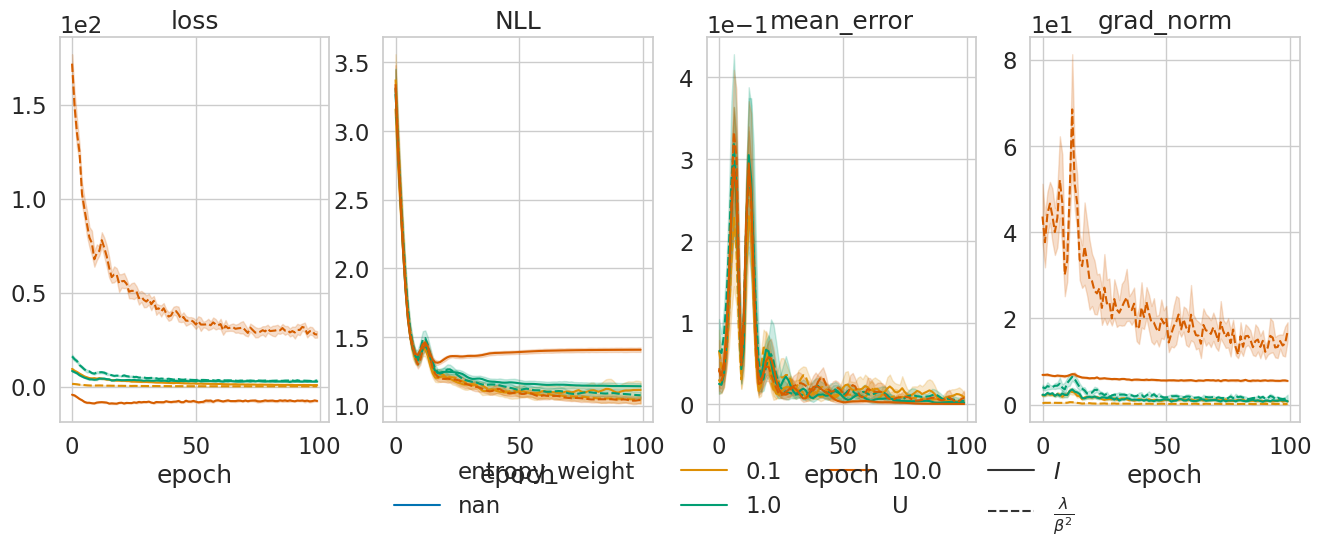

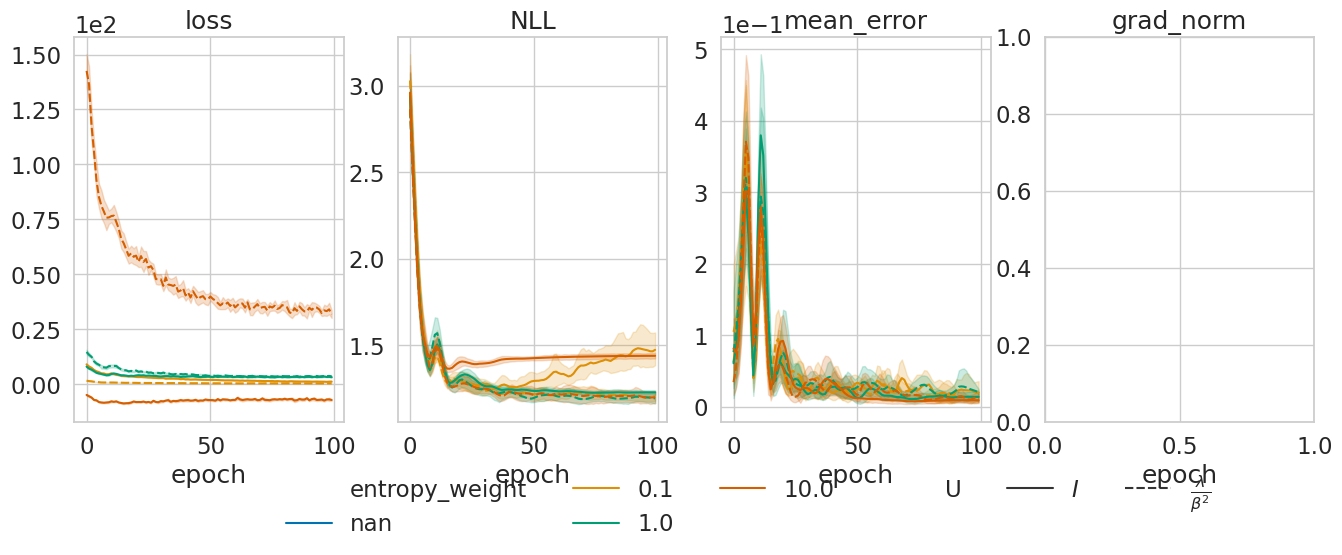

In [37]:
plot_ablation(
    df=df_all,
    hue_variable="entropy_weight",
    style_variable="U",
    loss_type_list=[],
    use_rsample_list=[],
    n_generations_list=[],
    entropy_weight_list=[],
    reward_transform_list=[],
)